In [ ]:
#@title Copyright 2020 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Detecting Changes in Sentinel-1 Imagery (Part 2)
Author: mortcanty





### Run me first

Run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [396]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='oasis-wa')

### Datasets and Python modules
One [dataset](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD) will be used in the tutorial:

- COPERNICUS/S1_GRD_FLOAT
    - Sentinel-1 ground range detected images

The following cell imports some python modules which we will be using as we go along and enables inline graphics.

In [397]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

And to make use of interactive graphics, we import the _folium_ package:

In [398]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

## Part 2. Hypothesis testing

We continue from [Part 1](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1) of the Tutorial with the area of interest _aoi_ covering the Frankfurt International Airport and a subset _aoi\_sub_  consisting of uniform pixels within a forested region.

In [399]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
           [
            [
              23.601997,
              56.637537
            ],
            [
              23.598564,
              56.566101
            ],
            [
              23.819309,
              56.570451
            ],
            [
              23.815533,
              56.639802
            ],
            [
              23.601997,
              56.637537
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
           [
            [
              23.627459,
              56.620967
            ],
            [
              23.679126,
              56.626681
            ],
            [
              23.662304,
              56.605712
            ],
            [
              23.639646,
              56.60642
            ],
            [
              23.627459,
              56.620967
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

This time we filter the S1 archive to get an image collection consisting of two images acquired in the  month of August, 2020. Because we are interested in change detection, it is essential that the local incidence angles be the same in both images. So now we specify both the orbit pass (ASCENDING) as well the relative orbit number (15) (find relative orbit in [S1 acquisition plan KMLs](https://sentinel.esa.int/web/sentinel/copernicus/sentinel-1/acquisition-plans) or the [Acquisition Plan Viewer](https://app.spectator.earth/acquisition-plan)):

In [423]:
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                 .filterBounds(aoi)
                .filterDate(ee.Date('2024-07-13'),ee.Date('2024-08-06'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 58))
                .sort('system:time_start'))

Here are the acquisition times in the collection, formatted with Python's _time_ module:

In [424]:
import time
acq_times = im_coll.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

['07/24/24', '08/05/24']

### A ratio image

Let's select the first two images and extract the VV bands,  clipping them to _aoi\_sub_,

In [425]:
im_list = im_coll.toList(im_coll.size())
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi_sub)
im2 = ee.Image(im_list.get(1)).select('VV').clip(aoi_sub)

Now we'll build the ratio of the VV bands and display it


In [426]:
ratio = im1.divide(im2)
url = ratio.getThumbURL({'min': 0, 'max': 10})
disp.Image(url=url, width=800)

As in the first part of the Tutorial, standard GEE reducers can be used to calculate a histogram, mean and variance of the ratio image:

In [427]:
hist = ratio.reduceRegion(ee.Reducer.fixedHistogram(0, 5, 500), aoi_sub).get('VV').getInfo()
mean = ratio.reduceRegion(ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
variance = ratio.reduceRegion(ee.Reducer.variance(), aoi_sub).get('VV').getInfo()

Here is a plot of the (normalized) histogram using _numpy_ and _matplotlib_:

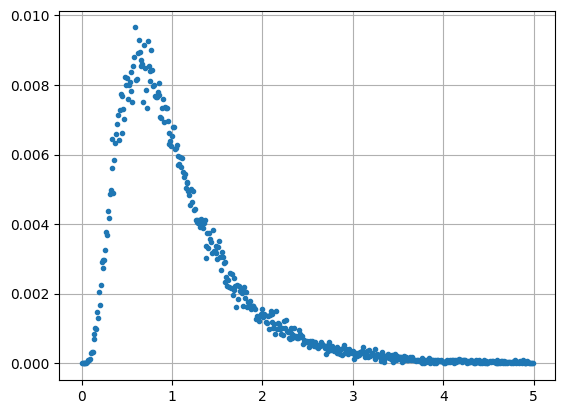

In [428]:
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.grid()
plt.plot(x, y, '.')
plt.show()

This looks a bit like the gamma distribution we met in [Part 1](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1#pixel_distributions) but is in fact an _F probability distribution_. The _F_ distribution is defined as the ratio of two chi square distributions, see [Eq. (1.12)](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1#speckle), with $m_1$ and $m_2$ degrees of freedom. The above histogram is an $F$ distribution  with $m_1=2m$ and $m_2=2m$ degrees of freedom and is given by

$$
p_{f;2m,2m}(x) = {\Gamma(2m)\over \Gamma(m)^2} x^{m-1}(1+x)^{-2m},
$$

$$
\quad {\rm mean}(x) = {m\over m-1},\tag{2.1}
$$

$$
\quad {\rm var}(x) = {m(2m-1)\over (m-1)^2 (m-2)}
$$

with parameter $m = 5$. We can see this empirically by overlaying the distribution onto the histogram with the help of _scipy.stats.f_. The histogram bucket widths are 0.01 so we have to divide by 100:

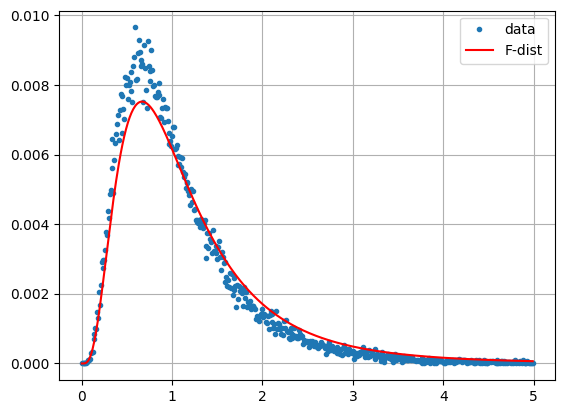

In [429]:
m = 5
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, f.pdf(x, 2*m, 2*m) / 100, '-r', label='F-dist')
plt.legend()
plt.show()

Checking the mean and variance, we get approximate agreement

In [430]:
print(mean, m/(m-1))
print(variance, m*(2*m-1)/(m-1)**2/(m-2))

1.0894674049837865 1.25
0.567808508019358 0.9375


So what is so special about this distribution? When looking for changes between two co-registered Sentinel-1 images acquired at different times, it might seem natural to subtract one from the other and then examine the difference, much as we would do for instance with visual/infrared ground reflectance images. In the case of SAR intensity images this is not a good idea. In the difference of two uncorrelated multilook images $\langle s_1\rangle$ and $\langle s_2\rangle$ the variances add together and, from Eq. (1.21) in the first part of the Tutorial,

$$
{\rm var}(\langle s_1\rangle-\langle s_2\rangle) = {a_1^2+a_2^2\over m}, \tag{2.4}
$$

where $a_1$ and $a_2$ are mean intensities. So difference pixels in bright areas will have a higher variance than difference pixels in darker areas. It is not possible to set a reliable threshold to determine with a given confidence where change has occurred.

It turns out that the _F_ distributed ratio of the two images which we looked at above is much more informative. For each pixel position in the two images, the quotient $\langle s_1\rangle / \langle s_2\rangle$ is a _likelihood ratio test statistic_ for deciding whether or not a change has occurred between the two acquisition dates at that position. We will explain what this means below. Here for now is the ratio of the two  Frankfurt Airport images, this time within the complete _aoi_:

In [431]:
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi)
im2 = ee.Image(im_list.get(1)).select('VV').clip(aoi)
ratio = im1.divide(im2)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_child(folium.LayerControl())

display(mp)

We might guess that the bright pixels here are significant changes, for instance due to aircraft movements on the tarmac or vehicles moving on the highway. Of course ''significant'' doesn't necessarily imply ''interesting''. We already know Frankfurt has a busy airport and that a German Autobahn is always crowded. The question is, how significant are the changes in the statistical sense? Let's now try to answer that question.

### Statistical testing


A _statistical hypothesis_ is a conjecture about the distributions of one or more measured variables. It might, for instance, be an assertion about the mean of a distribution, or about the equivalence of the variances of two different distributions. We distinguish between _simple_ hypotheses, for which the distributions are completely specified, for example: _the mean of a normal distribution with  variance $\sigma^2$  is  $\mu=0$_, and _composite_ hypotheses, for which this is not the case, e.g., _the mean is $\mu\ge 0$_.

In order to test such assertions on the basis of measured values, it is also necessary to formulate _alternative_ hypotheses. To distinguish these from the original assertions, the latter are traditionally called _null_ hypotheses. Thus we might be interested in testing the simple null hypothesis $\mu = 0$ against the composite alternative hypothesis $\mu\ne 0$. An appropriate combination of measurements for deciding whether or not to reject the null hypothesis in favor of its alternative is referred to as a _test statistic_, often denoted by the symbol $Q$. An appropriate _test procedure_ will partition the possible test statistics into two subsets: an acceptance region for the null hypothesis and a rejection region. The latter is customarily referred to as the _critical region_.

Referring to the null hypothesis as $H_0$, there are two kinds of errors which can arise from any test procedure:

  - $H_0$ may be rejected when in fact it is true. This is called an _error of the first kind_ and the probability that it will occur is denoted $\alpha$.
  - $H_0$ may be accepted when in fact it is false, which is called an _error of the second kind_ with probability of occurrence $\beta$.

The probability of obtaining a value of the test statistic within the critical region when $H_0$ is true is thus $\alpha$. The probability $\alpha$ is also referred to as the _level of significance_ of the test or the _probability of a false positive_. It is generally the case that the lower the value of $\alpha$, the higher is the probability $\beta$ of making a second kind error, so there is always a trade-off. (Judge Roy Bean, from the film of the same name, didn't believe in trade-offs. He hanged all defendants regardless of the evidence. His $\beta$ was zero, but his $\alpha$ was rather large.)

At any rate, traditionally, significance levels of 0.01 or 0.05 are often used.

#### The _P_ value

Suppose we determine the test statistic to have the value $q$. The _P value_ is defined as the probability of getting a test statistic $Q$ that is at least as extreme as the one observed given the null hypothesis. What is meant by "extreme" depends on how we choose the test statistic. If this probability is small, then the null hypothesis is unlikely. If it is smaller than the prescribed significance level $\alpha$, then the null hypothesis is rejected.

#### Likelihood Functions

The $m$-look VV intensity bands of the two Sentinel-1 images that we took from the archive have pixel values

$$
\langle s\rangle=\langle|S_{vv}|^2\rangle, \quad {\rm with\  mean}\ a=|S^a_{vv}|^2,
$$

and are _gamma_ distributed according to [Eq. (1.1)](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1#pixel_distributions), with parameters $\alpha=m$ and $\beta = a/m$. To make the notation a bit simpler, let's write $s =  \langle s \rangle$, so that the multi-look averaging is understood.

Using subscript $i=1,2$ to refer to the two images, the probability densities are

$$
p(s_i| a_i) = {1 \over (a_i/m)^m\Gamma(m)}s_i^{m-1}e^{-s_i m/a_i},\quad i=1,2. \tag{2.5}
$$

We've left out the number of looks $m$ on the left hand side, since it is the same for both images.

Now let's formulate a null hypothesis, namely that no change has taken place in the signal strength $a = |S^a_{vv}|^2$ between the two acquisitions, i.e.,

$$
H_0: \quad a_1=a_2 = a
$$

and test it against the alternative hypothesis that a change took place

$$
H_1: \quad a_1\ne a_2.
$$

If the null hypothesis is true, then the so-called _likelihood_ for getting the measured pixel intensities $s_1$ and $s_2$ is defined as the product of the probability densities for that value of $a$,

$$
L_0(a) = p(s_1|a)p(s_2|a) = {1\over(a/m)^{2m}\Gamma(m)^2}(s_1s_2)^{m-1}e^{-(s_1+s_2)m/a}. \tag{2.6}
$$

Taking the product of the probability densities like this is justified by the fact that the measurements $s_1$ and $s_2$ are independent.

The _maximum likelihood_ is obtained by maximizing $L_0(a)$ with respect to  $a$,

$$
L_0(\hat a) = p(s_1|\hat a)p(s_2|\hat a), \quad \hat a = \arg\max_a L_0(a).
$$

We can get $\hat a$ simply by solving the equation

$$
{d L_0(a)\over da} = 0
$$

for which we derive the maximum likelihood estimate (an easy exercise)

$$
\hat a = {s_1 + s_2 \over 2}.
$$

Makes sense: the only information we have is $s_1$ and $s_2$, so, if there was no change, our best estimate of the intensity $a$ is to take the average. Thus, substituting this value into Eq. (2.6), the maximum likelihood under $H_0$ is

$$
L_0(\hat a) = {1\over ((s_1+s_2)/2m)^{2m}\Gamma(m)^2}(s_1s_2)^{m-1}e^{-2m}. \tag{2.7}
$$

Similarly, under the alternative hypothesis $H_1$, the maximum likelihood is

$$
L_1(\hat a_1,\hat a_2) = p(s_1|\hat a_1)p(s_2|\hat a_2)\quad \hat a_1, \hat a_2 = \arg\max_{a_1,a_2} L_1(a_1,a_2).
$$

Again, setting derivatives equal to zero, we get for $H_1$

$$
\hat a_1 = s_1, \quad \hat a_2 = s_2,
$$

and the maximum likelihood

$$
L_1(\hat a_1,\hat a_2) = {m^{2m}\over \Gamma(m)^2}s_1s_2 e^{-2m}. \tag{2.8}
$$



### The Likelihood Ratio Test

The theory of statistical testing specifies methods for
determining the most appropriate test procedure, one which minimizes the probability $\beta$ of an error of the second kind  for a fixed level of significance $\alpha$. Rather than giving a general definition, we state the appropriate test for our case:

We should reject the null hypothesis if the _ratio_ of the two likelihoods satisfies the inequality

$$
Q = {L_0(\hat a)\over L_1(\hat a_1,\hat a_2)} \le k \tag{2.9}
$$

for some appropriately small value of threshold $k$.

This definition simply reflects the fact that, if the null hypothesis is true, the maximum likelihood when $a_1=a_2$ should be close to the maximum likelihood without that restriction, given the measurements $s_1$ and $s_2$. Therefore, if the likelihood ratio is small, (less than or equal to some small value $k$), then $H_0$ should be rejected.

With some (very) simply algebra, Eq. (2.9) evaluates to

$$
Q = \left[2^2 \left( s_1s_2\over (s_1+s_2)^2\right)\right]^m \le k \tag{2.10}
$$

using (2.7) and (2.8). This is the same as saying

$$
{s_1s_2\over (s_1+s_2)^2} \le k'\quad {\rm or}\quad {(s_1+s_2)^2\over s_1s_2}\ge k''\quad {\rm or}\quad  {s_1\over s_2}+{s_2\over s_1}\ge k''-2
$$

where $k',k''$ depend on $k$. The last inequality is satisfied if either term is small enough:

$$
{s_1\over s_2} < c_1 \quad {\rm or}\quad {s_2\over s_1} < c_2 \tag{2.11}
$$

again for some appropriate threshold $c_1$ and $c_2$ which depend on $k''$.

So the ratio image $s_1/s_2$ that we generated above is indeed a _Likelihood Ratio Test (LRT) statistic_, one of two possible. We'll call it $Q_1 = s_1/s_2$ and the other one $Q_2 = s_2/s_1$. The former tests for a significant increase in intensity between times $t_1$ and $t_2$, the latter for a significant decrease.

Fine, but where does the _F_ distribution come in?

Both $s_1$ and $s_2$ are gamma distributed

$$
p(s\mid a) = {1\over (a/m)^m\Gamma(m)}s^{m-1}e^{-sm/a}.
$$

Let $z = 2sm/a$. Then

$$
p(z\mid a) = p(s\mid a)\left |{ds\over dz}\right | = {1\over (a/m)^m\Gamma(m)}\left({za\over 2m}\right)^{m-1}\left({a\over 2m}\right) = {1\over 2^m\Gamma(m)}z^{m-1}e^{-z/2}.
$$

Comparing this with [Eq. (1.12)](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1#speckle) from the first part of the Tutorial, we see that $z$ is chi square distributed with $2m$ degrees of freedom, and therefore so are the variables $2s_1m/a$ and $2s_2m/a$. The quotients $s_1/s_2$ and $s_2/s_1$ are thus ratios of two chi square distributed variables with $2m$ degrees of freedom. They therefore have the _F_ distribution of Eq. (2.1).

In order to decide the test for $Q_1$, we need the _P_ value for a measurement $q_1$ of the statistic. Recall that this is the probability of getting a result at least as extreme as the one measured under the null hypothesis. So in this case

$$
P_1 = {\rm Prob}(Q_1\le q_1\mid H_0), \tag{2.12}
$$

which we can calculate from the percentiles of the _F_ distribution, Eq. (2.1). Then if $P_1\le \alpha/2$ we reject $H_0$ and conclude with significance $\alpha/2$ that a change occurred. We do the same test for $Q_2$, so that the combined significance is $\alpha$.

Now we can make a change map for the Frankfurt Airport for the two acquisitions, August 5 and August 11, 2020. We want to see quite large changes associated primarily with airplane and vehicle movements, so we will set the significance generously low to $\alpha = 0.001$. We will also distinguish the direction of change and mask out the no-change pixels:

In [14]:
# Decision threshold alpha/2:
dt = f.ppf(0.0005, 2*m, 2*m)

# LRT statistics.
q1 = im1.divide(im2)
q2 = im2.divide(im1)

# Change map with 0 = no change, 1 = decrease, 2 = increase in intensity.
c_map = im1.multiply(0).where(q2.lt(dt), 1)
c_map = c_map.where(q1.lt(dt), 2)

# Mask no-change pixels.
c_map = c_map.updateMask(c_map.gt(0))

# Display map with red for increase and blue for decrease in intensity.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(
    location=location, tiles='cartodb positron',
    zoom_start=13)
folium.TileLayer('OpenStreetMap').add_to(mp)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_ee_layer(c_map,
                {'min': 0, 'max': 2, 'palette': ['black', 'blue', 'red']},
                'Change Map')
mp.add_child(folium.LayerControl())

display(mp)

Most changes are within the airport or on the Autobahn. Barge movements on the Main River (upper left hand corner) are also signaled as significant changes. Note that the 'red' changes (significant increases in intensity) do not show up in the 'ratio' overlay, which displays $s_1/s_2$.

### Bivariate change detection

Rather than analyzing the VV and VH bands individually, it would make more sense to treat them together, and that is what we will now do. It is convenient to work with the covariance matrix form for measured intensities that we introduce in Part 1, see [Eq.(1.6a)](https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-1#single_look_complex_slc_sar_measurements). Again with the aim of keeping the notation simple, define

$$
\pmatrix{ s_i & 0\cr 0 & r_i} = \pmatrix{\langle|S_{vv}|^2\rangle_i & 0 \cr 0 & \langle|S_{vh}|^2\rangle_i}, \quad {\rm with\ means}\quad a_i = \langle|S^{a_i}_{vv}|^2\rangle, \quad b_i = \langle|S^{b_i}_{vh}|^2\rangle \tag{2.13}
$$

for the two acquisition times $t_i,\ i=1,2$.

Under $H_0$ we have $a_1=a_2=a$ and $b_1=b_2=b$. Assuming independence of $s_i$ and $r_i$, the likelihood function is the product of the four gamma distributions

$$
L_0(a,b) = p(s_1\mid a)p(r_1\mid b)p(s_2\mid a)p(r_2\mid b).
$$

Under $H_1$,

$$
L_1(a_1,b_1,a_2,b_2) = p(s_1\mid a_1)p(r_1\mid b_1)p(s_2\mid a_2)p(r_2\mid b_2).
$$

With maximum likelihood estimates under $H_0$

$$
\hat a = (s_1+s_2)/2\quad {\rm and}\quad \hat b = (r_1+r_2)/2
$$

for the parameters and some simple algebra, we get

$$
L_0(\hat a,\hat b) = {(2m)^{4m}\over (s_1+s_2)^{2m}(r_1+r_2)^{2m}\Gamma(m)^4}s_1r_1s_2r_2e^{-4m}. \tag{2.14}
$$

Similarly with $\hat a_1=s_1,\ \hat b_1=r_1,\ \hat a_2=s_2,\ \hat b_2=r_2$, we calculate

$$
L_1(\hat a_1,\hat b_1,\hat a_2,\hat b_2) = {m^{4m}\over s_1r_1s_2r_2}e^{-4m}.
$$

The likelihood test statistic in then

$$
Q = {L_0(\hat a,\hat b)\over L_1(\hat a_1,\hat b_1,\hat a_2,\hat b_2)}={2^4(s_1r_1s_2r_2)^m\over (s_1+s_2)^{2m}(r_1+r_2)^{2m}}.
$$

Writing this in terms of the covariance matrix representation,

$$
c_i = \pmatrix{s_i & 0\cr 0 & r_i},\quad i=1,2,
$$

we derive, finally, the likelihood ratio test

$$
Q = \left[2^4\pmatrix{|c_1| |c_2|\over |c_1+c_2|^2 }\right]^m \le k, \tag{2.15}
$$

where $|\cdot|$ indicates the matrix determinant, $|c_i|=s_ir_i$.

So far so good. But in order to determine _P_ values, we need the probability distribution of $Q$. This time we have no idea how to obtain it. Here again, statistical theory comes to our rescue.


Let $\Theta$ be the parameter space for the LRT. In our example it is
$$
\Theta = \{ a_1,b_1,a_2,b_2\}
$$
and has $d=4$ dimensions. Under the null hypothesis the parameter space is restricted by the conditions $a=a_1=a_2$ and $b=b_1=b_2$ to
$$
\Theta_0 = \{ a,b\}
$$
with $d_0=2$ dimensions. According to [Wilks' Theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem), as the number of measurements determining the LRT statistic $Q$ approaches $\infty$, the test statistic $-2\log Q$ approaches a chi square distribution with $d-d_0=2$ degrees of freedom. (Recall that, in order to determine the matrices $c_1$ and $c_2$, five individual measurements were averaged or multi-looked.) So rather than working with $Q$ directly, we use $-2\log Q$ instead and hope that Wilk's theorem is a good enough approximation for our case.

In order to check if this is so, we just have to program

$$
-2\log Q = (\log{|c_1|}+\log{|c_2|}-2\log{|c_1+c_2|}+4\log{2})(-2m)
$$

in GEE-ese:

In [15]:
def det(im):
  return im.expression('b(0) * b(1)')

# Number of looks.
m = 5

im1 = ee.Image(im_list.get(0)).select('VV', 'VH').clip(aoi)
im2 = ee.Image(im_list.get(1)).select('VV', 'VH').clip(aoi)

m2logQ = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

and then plot its histogram, comparing it with the chi square distribution _scipy.stats.chi2.pdf()_ with two degrees of freedom:

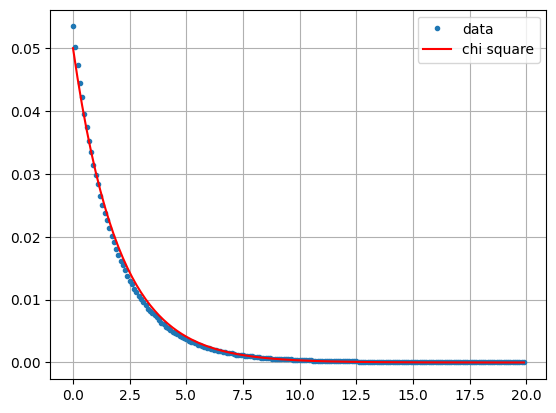

In [16]:
hist = m2logQ.reduceRegion(
    ee.Reducer.fixedHistogram(0, 20, 200), aoi).get('VV').getInfo()
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, 2)/10, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

Looks pretty good. Note now that a small value of the LRT $Q$ in Eq. (2.15) corresponds to a large value of $-2\log{Q}$. Therefore the _P_ value for a measurement $q$ is now the probability of getting the value $-2\log{q}$
or higher,
$$
P = {\rm Prob}(-2\log{Q} \ge -2\log{q}) = 1 - {\rm Prob}(-2\log{Q} < -2\log{q}).
$$

So let's try out our bivariate change detection procedure, this time on an agricultural scene where we expect to see larger regions of change.

In [ ]:
geoJSON ={
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -98.2122802734375,
              49.769291532628515
            ],
            [
              -98.00559997558594,
              49.769291532628515
            ],
            [
              -98.00559997558594,
              49.88578690918283
            ],
            [
              -98.2122802734375,
              49.88578690918283
            ],
            [
              -98.2122802734375,
              49.769291532628515
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi1 = ee.Geometry.Polygon(coords)

This is a mixed agricultural/forest area in southern Manitoba, Canada. We'll gather two images, one from the beginning of August and one from the beginning of September, 2018. A lot of harvesting takes place in this interval, so we expect some extensive changes.

In [ ]:
im1 = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi1)
                .filterDate(ee.Date('2018-08-01'), ee.Date('2018-08-31'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 136))
                .first()
                .clip(aoi1))
im2 = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT').filterBounds(aoi1)
                .filterDate(ee.Date('2018-09-01'), ee.Date('2018-09-30'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 136))
                .first()
                .clip(aoi1))

Here are the acquisition times:

In [ ]:
acq_time = im1.get('system:time_start').getInfo()
print( time.strftime('%x', time.gmtime(acq_time/1000)) )
acq_time = im2.get('system:time_start').getInfo()
print( time.strftime('%x', time.gmtime(acq_time/1000)) )

Fortunately it is possible to map the chi square cumulative distribution function over an _ee.Image()_  so that a _P_ value image can be calculated directly. This wasn't possible in the single band case, as the _F_ cumulative distribution is not available on the GEE. Here are the _P_ values:

In [ ]:
def chi2cdf(chi2, df):
  ''' Chi square cumulative distribution function for df degrees of freedom
      using the built-in incomplete gamma function gammainc() '''
  return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

# The observed test statistic image -2logq.
m2logq = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

# The P value image prob(m2logQ > m2logq) = 1 - prob(m2logQ < m2logq).
p_value = ee.Image.constant(1).subtract(chi2cdf(m2logq, 2))

# Project onto map.
location = aoi1.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(p_value,
                {'min': 0,'max': 1, 'palette': ['black', 'white']}, 'P-value')
mp.add_child(folium.LayerControl())

The uniformly dark areas correspond to small or vanishing _P_ values and signify change. The bright areas correspond to no change. Why they are not uniformly bright will be explained below. Now we set a significance threshold of $\alpha=0.01$ and display the significant changes, whereby 1% of them will be false positives. For reference we also show the 2018 [Canada AAFC Annual Crop Inventory](https://developers.google.com/earth-engine/datasets/catalog/AAFC_ACI) map, which is available as a GEE collection:

In [ ]:
c_map = p_value.multiply(0).where(p_value.lt(0.01), 1)

crop2018 = (ee.ImageCollection('AAFC/ACI')
             .filter(ee.Filter.date('2018-01-01', '2018-12-01'))
             .first()
             .clip(aoi1))

mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(crop2018, {min: 0, max: 255}, 'crop2018')
mp.add_ee_layer(c_map.updateMask(
    c_map.gt(0)), {'min': 0, 'max': 1, 'palette': ['black', 'red']}, 'c_map')
mp.add_child(folium.LayerControl())

 The major crops in the scene are soybeans (dark brown), oats (light brown), canola (light green), corn (light yellow) and winter wheat (dark gray). The wooded areas exhibit little change, while canola has evidently been extensively harvested in the interval.

#### A note on _P_ values
Because small _P_ values are indicative of change, it is tempting to say that, the larger the _P_ value, the higher the probability of no change. Or more explicitly, the _P_ value is itself the no change probability. Let's see why this is false. Below we choose a wooded area of the agricultural scene where few significant changes are to be expected and use it to subset the _P_ value image. Then we plot the histogram of the subset:

In [ ]:
geoJSON ={
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -98.18550109863281,
              49.769735012247885
            ],
            [
              -98.13949584960938,
              49.769735012247885
            ],
            [
              -98.13949584960938,
              49.798109268622
            ],
            [
              -98.18550109863281,
              49.798109268622
            ],
            [
              -98.18550109863281,
              49.769735012247885
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi1_sub = ee.Geometry.Polygon(coords)
hist = p_value.reduceRegion(ee.Reducer.fixedHistogram(0, 1, 100), aoi1_sub).get('constant').getInfo()
a = np.array(hist)
x = a[:,0]
y = a[:,1]/np.sum(a[:,1])
plt.plot(x, y, '.b', label='p-value')
plt.ylim(0, 0.05)
plt.grid()
plt.legend()
plt.show()

So the P values of no-change measurements are uniformly distributed over $[0, 1]$ (the excess of small _P_ values at the left can be ascribed to genuine changes within the polygon). A large _P_ value is no more indicative of no change than a small one. Of course it has to be this way. When, for example, we set a significance level of 5%, then the fraction of false positives, i.e., the fraction of _P_ values smaller than 0.05 given $H_0$, must also be 5%. This accounts for the noisy appearance of the _P_ value image in the no-change regions.

#### Change direction: the Loewner order
What about the direction of change in the bivariate case? This is less clear, as we can have the situation where the VV intensity gets larger and the VH smaller from time $t_1$ to $t_2$, or vice versa. When we are dealing with the C2 covariance matrix representation of SAR imagery, see Eq. (2.13), a characterization of change can be made as follows [(Nielsen et al. (2019))](https://ieeexplore.ieee.org/document/8736751): For each significantly changed pixel, we determine the difference $C2_{t_2}-C2_{t_1}$ and examine its so-called _definiteness_, also known as the _Loewner order_ of the change. A matrix is said to be _positive definite_ if all of its eigenvalues are positive, _negative definite_ if they are all negative, otherwise _indefinite_. In the case of the $2\times 2$ diagonal matrices that we are concerned with the eigenvalues are just the two diagonal elements themselves, so determining the Loewner order is trivial. For full $2\times 2$ dual pol or $3\times 3$ quad pol SAR imagery, devising an efficient way to determine the Loewner order is more difficult, see [Nielsen (2019)](https://ieeexplore.ieee.org/document/8913617).

So let's include the Loewner order in our change map:

In [ ]:
c_map = p_value.multiply(0).where(p_value.lt(0.01), 1)
diff = im2.subtract(im1)
d_map = c_map.multiply(0)                    # Initialize the direction map to zero.
d_map = d_map.where(det(diff).gt(0), 2)      # All pos or neg def diffs are now labeled 2.
d_map = d_map.where(diff.select(0).gt(0), 3) # Re-label pos def (and label some indef) to 3.
d_map = d_map.where(det(diff).lt(0), 1)      # Label all indef to 1.
c_map = c_map.multiply(d_map)                # Re-label the c_map, 0*X = 0, 1*1 = 1, 1*2= 2, 1*3 = 3.

Now we display the changes, with positive definite red, negative definite blue, and indefinite yellow:

In [ ]:
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(crop2018, {min: 0, max: 255}, 'crop2018')
mp.add_ee_layer(
    c_map.updateMask(c_map.gt(0)), {
        'min': 0,
        'max': 3,
        'palette': ['black', 'yellow', 'blue', 'red']
    }, 'c_map')
mp.add_child(folium.LayerControl())

The more or less compact blue changes indicate a decrease in reflectivity in both VV and VH bands, and correspond to crop harvesting (especially canola).



### Outlook
We have now covered the subject of bitemporal change detection with GEE Sentinel-1 imagery. The beauty of GEE is that it is trivially easy to gather arbitrarily long time series of S1 images from the archive, all with revisit times of 6 or 12 days depending on whether one or both satellites are collecting data. The next part of the Tutorial will generalize the techniques we have learned so far to treat multitemporal change detection.

### Oh, and one more thing ...

We didn't mention it above, but note the similarity between Eq. (2.10) and Eq. (2.15). To go from the monovariate LRT to the bivariate LRT, we simply replace the product of  intensities $s_1s_2$ by the product of determinants $|c_1||c_2|$, the sum $s_1+s_2$ by $|c_1+c_2|$ and the factor $2^{2}$ by $2^4=2^{2\cdot2}$. This observation will come in handy in Part 3.